# Ridge regression examples

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
* Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression
* Use matplotlib to visualize polynomial regressions
* Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression, this time with L2 penalty
* Use matplotlib to visualize polynomial regressions under L2 regularization
* Choose best L2 penalty using cross-validation.
* Assess the final fit using test data.

These notes follow the UW machine learning course sequence.

In [1]:
import numpy as np
import graphlab as gl
import matplotlib.pyplot as plt

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1576362438.log


This non-commercial license of GraphLab Create for academic use is assigned to thetoozin@gmail.com and will expire on February 06, 2020.


## Polynomial regression, revisited

The function `polynomial_sframe` produces an SFrame with columns containing the powers of a given input. 

In [2]:
def polynomial_sframe(feature, degree):
    
    # input: SArray
    # output: SFrame = SArray^1 | SArray^2 | ... | SArray^degree

    poly_sframe = gl.SFrame()
    poly_sframe['power_1'] = feature
    # and set poly_sframe['power_1'] equal to the passed feature

    # first check if degree > 1
    if degree > 1:
        for power in range(2, degree+1): 
            name = 'power_' + str(power)
            poly_sframe[name] = poly_sframe['power_1'].apply(lambda x: x**power)

    return poly_sframe

Let's use matplotlib to visualize what a polynomial regression looks like on the house data.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sales = gl.SFrame('kc_house_data.gl/')

Let's use the sqft_living variable. For plotting purposes (connecting the dots), we sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [5]:
sales = sales.sort(['sqft_living','price'])

In [6]:
sales.head(4)

Columns:
	id	str
	date	datetime
	price	float
	bedrooms	float
	bathrooms	float
	sqft_living	float
	sqft_lot	int
	floors	str
	waterfront	int
	view	int
	condition	int
	grade	int
	sqft_above	int
	sqft_basement	int
	yr_built	int
	yr_renovated	int
	zipcode	str
	lat	float
	long	float
	sqft_living15	float
	sqft_lot15	float

Rows: 4

Data:
+------------+---------------------------+----------+----------+-----------+
|     id     |            date           |  price   | bedrooms | bathrooms |
+------------+---------------------------+----------+----------+-----------+
| 3980300371 | 2014-09-26 00:00:00+00:00 | 142000.0 |   0.0    |    0.0    |
| 2856101479 | 2014-07-01 00:00:00+00:00 | 276000.0 |   1.0    |    0.75   |
| 1723049033 | 2014-06-20 00:00:00+00:00 | 245000.0 |   1.0    |    0.75   |
| 1222029077 | 2014-10-29 00:00:00+00:00 | 265000.0 |   0.0    |    0.75   |
+------------+---------------------------+----------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    290.0    |  20875   |   1    |     0      |  0   |     1     |   1   |    290     |
|    370.0    |   1801   |   1    |     0      |  0   |     5     |   5   |    370     |
|    380.0    |  15000   |   1    |     0      |  0   |     3     |   5   |    380     |
|    384.0    |  213444  |   1    |     0      |  0   |     3     |   4   |    384     |
+-------------+----------+--------+------------+------+-----------+-------+------------+
+---------------+----------+--------------+---------+-------------+
| sqft_basement | yr_built | yr_renovated | zipcode |     lat     |
+---------------+----------+--------------+---------+-------------+
|       0       |   1963   |      0       |  98024  | 47.53077245 |
|       0       |   1923   |      0       |  98117  | 47.67782145 |
|       0       |   1963   |      0       |  98168  | 47.48103428 |
|       0       |   2003   |      0       |  98070  | 47.41772688 |
+---------------+----------+--------------+---------+-------------+
+---------------+---------------+-----+
|      long     | sqft_living15 | ... |
+---------------+---------------+-----+
| -121.88842327 |     1620.0    | ... |
| -122.38911208 |     1340.0    | ... |
|  -122.322601  |     1170.0    | ... |
| -122.49121696 |     1920.0    | ... |
+---------------+---------------+-----+
[4 rows x 21 columns]

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_sframe()` and fit a model with these features. When fitting the model, use an L2 penalty of `1e-5`:

In [7]:
l2_small_penalty = 1e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, we fit the model and print out the learned weights.

In [8]:
dataDeg15 = polynomial_sframe(sales['sqft_living'],15)
deg15_features = dataDeg15.column_names()
dataDeg15['price'] =sales['price']

deg15model = gl.linear_regression.create(dataDeg15,target='price',features=deg15_features,l2_penalty=l2_small_penalty,validation_set=None,verbose=False)
print deg15model.get('coefficients')[1]

{'index': None, 'stderr': 4735.64035967028, 'name': 'power_1', 'value': 103.09095591973461}


## Observe overfitting

In [10]:
(semi_split1, semi_split2) = sales.random_split(.5,seed=0)
(set_1, set_2) = semi_split1.random_split(0.5, seed=0)
(set_3, set_4) = semi_split2.random_split(0.5, seed=0)

We fit a 15th degree polynomial on `set_1`, `set_2`, `set_3`, and `set_4`, using 'sqft_living' to predict prices. 

In [11]:
dataDeg15_set1 = polynomial_sframe(set_1['sqft_living'],15)
deg15_features1 = dataDeg15_set1.column_names()
dataDeg15_set1['price'] =set_1['price']
deg15model_1 = gl.linear_regression.create(dataDeg15_set1,target='price',features=deg15_features1,l2_penalty=l2_small_penalty,validation_set=None,verbose=False)

In [12]:
dataDeg15_set2 = polynomial_sframe(set_2['sqft_living'],15)
deg15_features2 = dataDeg15_set2.column_names()
dataDeg15_set2['price'] =set_2['price']
deg15model_2 = gl.linear_regression.create(dataDeg15_set2,target='price',features=deg15_features2,l2_penalty=l2_small_penalty,validation_set=None,verbose=False)

In [13]:
dataDeg15_set3 = polynomial_sframe(set_3['sqft_living'],15)
deg15_features3 = dataDeg15_set3.column_names()
dataDeg15_set3['price'] =set_3['price']
deg15model_3 = gl.linear_regression.create(dataDeg15_set3,target='price',features=deg15_features3,l2_penalty=l2_small_penalty,validation_set=None,verbose=False)

In [14]:
dataDeg15_set4 = polynomial_sframe(set_4['sqft_living'],15)
deg15_features4 = dataDeg15_set4.column_names()
dataDeg15_set4['price'] =set_4['price']
deg15model_4 = gl.linear_regression.create(dataDeg15_set4,target='price',features=deg15_features4,l2_penalty=l2_small_penalty,validation_set=None,verbose=False)

In [15]:
print 'We can see that the each model is quite different, for example the values of x^1-coefficient varies wildly among the four models:\n'

print deg15model_1.get('coefficients')[1]['value']
print deg15model_2.get('coefficients')[1]['value']
print deg15model_3.get('coefficients')[1]['value']
print deg15model_4.get('coefficients')[1]['value']

We can see that the each model is quite different, for example the values of x^1-coefficient varies wildly among the four models:

585.865823394
783.49380028
-759.251842854
1247.59034541


In [16]:
print deg15model_3.get('coefficients')[1]

{'index': None, 'stderr': nan, 'name': 'power_1', 'value': -759.2518428541024}


Let's plot the different models on the respective training data sets:

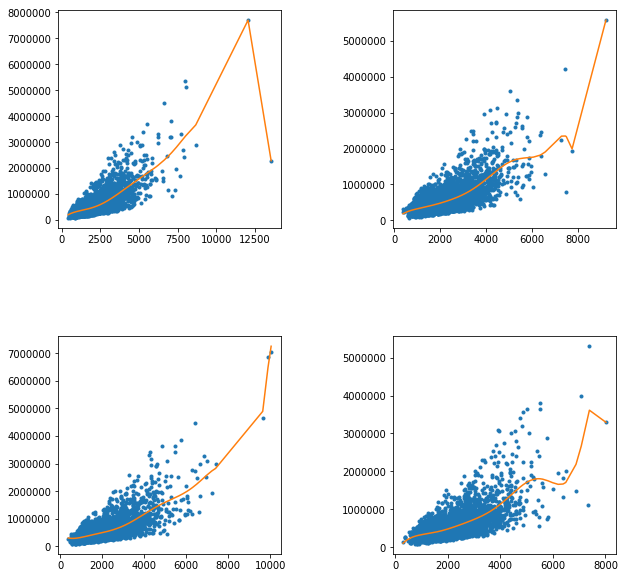

In [17]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
plt.plot(dataDeg15_set1['power_1'],dataDeg15_set1['price'],'.',dataDeg15_set1['power_1'],deg15model_1.predict(dataDeg15_set1),'-')
ax2 = plt.subplot(222)
plt.plot(dataDeg15_set2['power_1'],dataDeg15_set2['price'],'.',dataDeg15_set2['power_1'],deg15model_2.predict(dataDeg15_set2),'-')
ax3 = plt.subplot(223)
plt.plot(dataDeg15_set3['power_1'],dataDeg15_set3['price'],'.',dataDeg15_set3['power_1'],deg15model_3.predict(dataDeg15_set3),'-')
ax4 = plt.subplot(224)
plt.plot(dataDeg15_set4['power_1'],dataDeg15_set4['price'],'.',dataDeg15_set4['power_1'],deg15model_4.predict(dataDeg15_set4),'-')
plt.subplots_adjust(hspace=.5,wspace=.5)

## Ridge regression comes to rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (Weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

With the argument `l2_penalty=1e5`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty` parameter, the code should be the same as the experiment above. Also, make sure GraphLab Create doesn't create its own validation set by using the option `validation_set = None` in this call.

In [18]:
dataDeg15_set1 = polynomial_sframe(set_1['sqft_living'],15)
deg15_features1 = dataDeg15_set1.column_names()
dataDeg15_set1['price'] =set_1['price']
deg15model_1_ridge = gl.linear_regression.create(dataDeg15_set1,target='price',features=deg15_features1,l2_penalty=1e5,validation_set=None,verbose=False)

In [19]:
dataDeg15_set2 = polynomial_sframe(set_2['sqft_living'],15)
deg15_features2 = dataDeg15_set2.column_names()
dataDeg15_set2['price'] =set_2['price']
deg15model_2_ridge = gl.linear_regression.create(dataDeg15_set2,target='price',features=deg15_features2, l2_penalty=1e5, validation_set=None,verbose=False)


In [20]:
dataDeg15_set3 = polynomial_sframe(set_3['sqft_living'],15)
deg15_features3 = dataDeg15_set3.column_names()
dataDeg15_set3['price'] =set_3['price']
deg15model_3_ridge = gl.linear_regression.create(dataDeg15_set3,target='price',features=deg15_features3,l2_penalty=1e5, validation_set=None,verbose=False)


In [21]:
dataDeg15_set4 = polynomial_sframe(set_4['sqft_living'],15)
deg15_features4 = dataDeg15_set4.column_names()
dataDeg15_set4['price'] =set_4['price']
deg15model_4_ridge = gl.linear_regression.create(dataDeg15_set4,target='price',features=deg15_features4, l2_penalty=1e5, validation_set=None,verbose=False)


Now we have models which are closer to one another since we have reduced the variance level by the regularization step:

In [22]:
print deg15model_1_ridge.get('coefficients')[1]['value']
print deg15model_2_ridge.get('coefficients')[1]['value']
print deg15model_3_ridge.get('coefficients')[1]['value']
print deg15model_4_ridge.get('coefficients')[1]['value']

2.58738875673
2.04470474182
2.26890421877
1.91040938244


We plot the new regularized models:

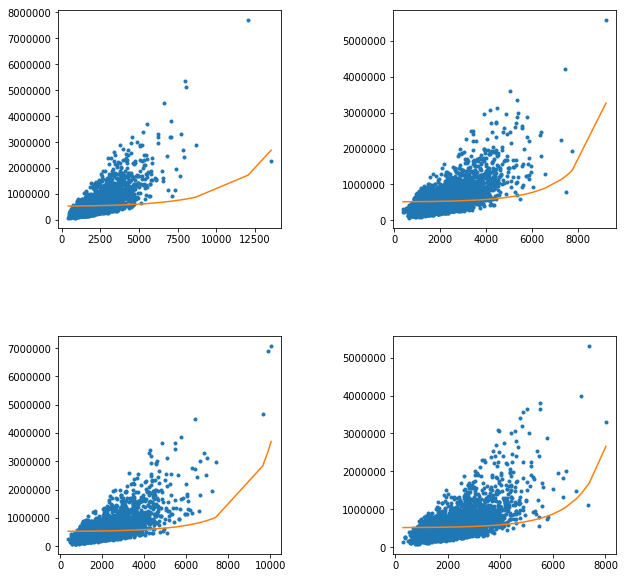

In [23]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
plt.plot(dataDeg15_set1['power_1'],dataDeg15_set1['price'],'.',dataDeg15_set1['power_1'],deg15model_1_ridge.predict(dataDeg15_set1),'-')
ax2 = plt.subplot(222)
plt.plot(dataDeg15_set2['power_1'],dataDeg15_set2['price'],'.',dataDeg15_set2['power_1'],deg15model_2_ridge.predict(dataDeg15_set2),'-')
ax3 = plt.subplot(223)
plt.plot(dataDeg15_set3['power_1'],dataDeg15_set3['price'],'.',dataDeg15_set3['power_1'],deg15model_3_ridge.predict(dataDeg15_set3),'-')
ax4 = plt.subplot(224)
plt.plot(dataDeg15_set4['power_1'],dataDeg15_set4['price'],'.',dataDeg15_set4['power_1'],deg15model_4_ridge.predict(dataDeg15_set4),'-')
plt.subplots_adjust(hspace=.5,wspace=.5)

These curves should vary a lot less, now that we applied a high degree of regularization.


## Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. **Cross-validation** seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called **k-fold cross-validation**. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
...<br>
Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that  all observations are used for both training and validation, as we iterate over segments of data. 

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. GraphLab Create has a utility function for shuffling a given SFrame. We reserve 10% of the data as the test set and shuffle the remainder. (Make sure to use `seed=1` to get consistent answer.)

In [24]:
(train_valid, test) = sales.random_split(.9, seed=1)
train_valid_shuffled = gl.toolkits.cross_validation.shuffle(train_valid, random_seed=1)

train_valid_shuffled_15 = polynomial_sframe(train_valid_shuffled['sqft_living'],15)
sqftLiving_features = train_valid_shuffled_15.column_names()
train_valid_shuffled_15['price'] = train_valid_shuffled['price']


Once the data is shuffled, we divide it into equal segments. Each segment should receive `n/k` elements, where `n` is the number of observations in the training set and `k` is the number of segments. Since the segment 0 starts at index 0 and contains `n/k` elements, it ends at index `(n/k)-1`. The segment 1 starts where the segment 0 left off, at index `(n/k)`. With `n/k` elements, the segment 1 ends at index `(n*2/k)-1`. Continuing in this fashion, we deduce that the segment `i` starts at index `(n*i/k)` and ends at `(n*(i+1)/k)-1`.

With this pattern in mind, we write a short loop that prints the starting and ending indices of each segment, just to make sure you are getting the splits right.

In [25]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in xrange(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1
    print i, (start, end)

0 (0, 1938)
1 (1939, 3878)
2 (3879, 5817)
3 (5818, 7757)
4 (7758, 9697)
5 (9698, 11636)
6 (11637, 13576)
7 (13577, 15515)
8 (15516, 17455)
9 (17456, 19395)


Let us familiarize ourselves with array slicing with SFrame. To extract a continuous slice from an SFrame, use colon in square brackets. For instance, the following cell extracts rows 0 to 9 of `train_valid_shuffled`. Notice that the first index (0) is included in the slice but the last index (10) is omitted.

In [26]:
train_valid_shuffled[0:10] # rows 0 to 9

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
2780400035,2014-05-05 00:00:00+00:00,665000.0,4.0,2.5,2800.0,5900,1,0
1703050500,2015-03-21 00:00:00+00:00,645000.0,3.0,2.5,2490.0,5978,2,0
5700002325,2014-06-05 00:00:00+00:00,640000.0,3.0,1.75,2340.0,4206,1,0
0475000510,2014-11-18 00:00:00+00:00,594000.0,3.0,1.0,1320.0,5000,1,0
0844001052,2015-01-28 00:00:00+00:00,365000.0,4.0,2.5,1904.0,8200,2,0
2658000373,2015-01-22 00:00:00+00:00,305000.0,4.0,2.0,1610.0,6250,1,0
3750603471,2015-03-27 00:00:00+00:00,239950.0,3.0,2.5,1560.0,4800,2,0
2114700540,2014-10-21 00:00:00+00:00,366000.0,3.0,2.5,1320.0,4320,1,0
2596400050,2014-07-30 00:00:00+00:00,375000.0,3.0,1.0,1960.0,7955,1,0
4140900050,2015-01-26 00:00:00+00:00,440000.0,4.0,1.75,2180.0,10200,1,0


Now let us extract individual segments with array slicing. Consider the scenario where we group the houses in the `train_valid_shuffled` dataframe into k=10 segments of roughly equal size, with starting and ending indices computed as above.
Extract the fourth segment (segment 3) and assign it to a variable called `validation4`.

In [27]:
validation4 =train_valid_shuffled[5818:7758]

To verify that we have the right elements extracted, run the following cell, which computes the average price of the fourth segment. When rounded to nearest whole number, the average should be $536,234.

In [28]:
print int(round(validation4['price'].mean(), 0))

536234


After designating one of the k segments as the validation set, we train a model using the rest of the data. To choose the remainder, we slice (0:start) and (end+1:n) of the data and paste them together. SFrame has `append()` method that pastes together two disjoint sets of rows originating from a common dataset. For instance, the following cell pastes together the first and last two rows of the `train_valid_shuffled` dataframe.

In [29]:
n = len(train_valid_shuffled)
first_two = train_valid_shuffled[0:2]
last_two = train_valid_shuffled[n-2:n]
print first_two.append(last_two)

+------------+---------------------------+-----------+----------+-----------+
|     id     |            date           |   price   | bedrooms | bathrooms |
+------------+---------------------------+-----------+----------+-----------+
| 2780400035 | 2014-05-05 00:00:00+00:00 |  665000.0 |   4.0    |    2.5    |
| 1703050500 | 2015-03-21 00:00:00+00:00 |  645000.0 |   3.0    |    2.5    |
| 4139480190 | 2014-09-16 00:00:00+00:00 | 1153000.0 |   3.0    |    3.25   |
| 7237300290 | 2015-03-26 00:00:00+00:00 |  338000.0 |   5.0    |    2.5    |
+------------+---------------------------+-----------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    2800.0   |   5900   |   1    |     0      |  0   |     3     |   8   |    1660    |
|    2490.0   |   59

Extract the remainder of the data after *excluding* fourth segment (segment 3) and assign the subset to `train4`.

In [30]:
train4 = train_valid_shuffled[0:5818]
train4 = train4.append(train_valid_shuffled[7758:])

To verify that we have the right elements extracted, run the following cell, which computes the average price of the data with fourth segment excluded. When rounded to nearest whole number, the average should be $539,450.

In [31]:
print int(round(train4['price'].mean(), 0))

539450


Now we are ready to implement k-fold cross-validation. Write a function that computes k validation errors by designating each of the k segments as the validation set. It accepts as parameters (i) `k`, (ii) `l2_penalty`, (iii) dataframe, (iv) name of output column (e.g. `price`) and (v) list of feature names. The function returns the average validation error using k segments as validation sets.

* For each i in [0, 1, ..., k-1]:
  * Compute starting and ending indices of segment i and call 'start' and 'end'
  * Form validation set by taking a slice (start:end+1) from the data.
  * Form training set by appending slice (end+1:n) to the end of slice (0:start).
  * Train a linear model using training set just formed, with a given l2_penalty
  * Compute validation error using validation set just formed

In [32]:
def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
    
    errorList_fixedPenalty = []
    n = len(data)  # data should be shuffled already
    for i in xrange(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        #print i, (start, end)
        validationSet = data[start:end+1]
        trainSet = data[end+1:n]
        trainSet = trainSet.append(data[0:start])
        
        model = gl.linear_regression.create(trainSet,target=output_name,features=features_list,l2_penalty=l2_penalty,verbose=False)
        y_pred = model.predict(validationSet)
        
        # compute error
        
        rss_error = ((validationSet['price'] - y_pred)**2).sum()
        errorList_fixedPenalty.append(rss_error)
    
    return errorList_fixedPenalty

In [33]:
[1,2,3,4].index(min([1,2,3,4]))

0

Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:
* We will again be aiming to fit a 15th-order polynomial model using the `sqft_living` input
* For `l2_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, you can use this Numpy function: `np.logspace(1, 7, num=13)`.)
    * Run 10-fold cross-validation with `l2_penalty`
* Report which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use `train_valid_shuffled` when generating polynomial features!

In [34]:
meanErr_per_penalty = []
for penalty in np.logspace(1,7,num=13):
    
    errors_at_given_penalty = []
    meanErrorList = k_fold_cross_validation(10, penalty, train_valid_shuffled_15,'price',sqftLiving_features)
    
    meanErr_per_penalty.append(sum(meanErrorList)/len(meanErrorList))

print 'Minimum RSS error: ', min(meanErr_per_penalty)
print 'Correspoding l2-penalty: ', np.logspace(1,7,num=13)[meanErr_per_penalty.index(min(meanErr_per_penalty))]
    


Minimum RSS error:  1.2103839545e+14
Correspoding l2-penalty:  1000.0


The best parameter value and the minimum value of l2 penalty it gives are:

In [35]:
print np.logspace(1,7,num=13)[meanErr_per_penalty.index(min(meanErr_per_penalty))]
print min(meanErr_per_penalty)
print np.logspace(1,7,num=13)[4]

1000.0
1.2103839545e+14
1000.0


***QUIZ QUESTIONS:  What is the best value for the L2 penalty according to 10-fold validation?***

You may find it useful to plot the k-fold cross-validation errors you have obtained to better understand the behavior of the method.  

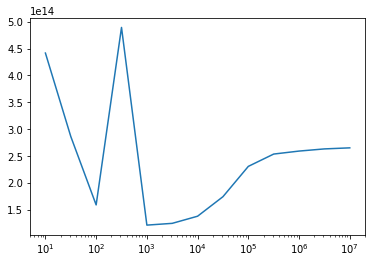

In [36]:
# Plot the l2_penalty values in the x axis and the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.

plt.figure()
plt.plot(np.logspace(1,7,num=13),meanErr_per_penalty)
plt.xscale('log')
plt.show()

Once you found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of `l2_penalty`. This way, your final model will be trained on the entire dataset.

In [37]:
dataDeg15_full = polynomial_sframe(train_valid['sqft_living'],15)
dataDeg15_full_features = dataDeg15_full.column_names()
dataDeg15_full['price'] =train_valid['price']
fullModel = gl.linear_regression.create(dataDeg15_full,target='price',features=dataDeg15_full_features,l2_penalty=1000,verbose=False)

The RSS on the test data:

In [38]:
((fullModel.predict(test) - test['price'])**2).sum()

252942432857851.0